In [14]:
%run ../_preamble.ipynb
from _work.src.data import small_dataloader as dataloader
from _work.src.models import AutoEncoder
from _work.src.modules.train import train_model, test_model
from _work.src.modules.replay import iterate
from _work.src.modules.utils import get_closest_item, round_tensor
from _work.src.modules.eval import eval_model
from _work.src.modules.plot import plot_metrics, plot_parameters, plot_tensor, plot_grid
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

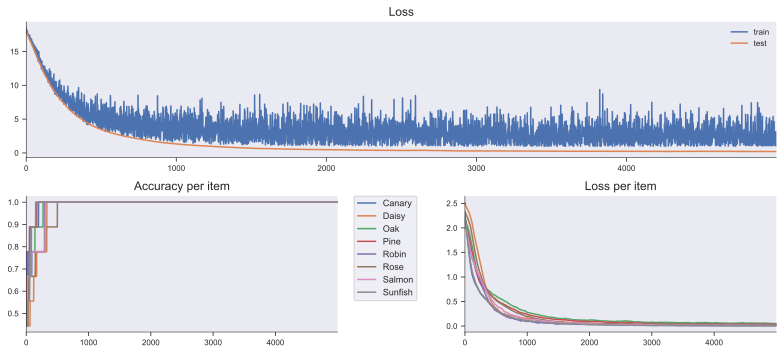

In [2]:
metrics1 = train_model(
    model1 := AutoEncoder(
        sizes=[dataloader.dataset.NUM_ATTRIBUTES, 8],
        batch_norm=False,
        dropout=0.15,
    ),
    optimizer1 := torch.optim.Adam(model1.parameters(), lr=1e-3),
    loss_fn1 := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=5000,
    l1_lambda=0.005,
    noise_mean=0,
    noise_stdev=1,
)

plot_metrics(metrics1);

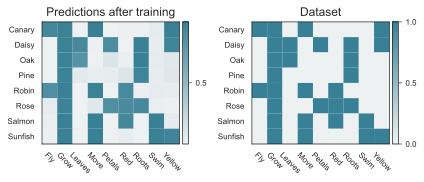

In [15]:
eval_model(model1, dataloader);

In [16]:
plot_grid(model1, dataloader)

[0.50336388 0.21345859]


array([5512, 3510, 2080,  546,  260,   78,    9])

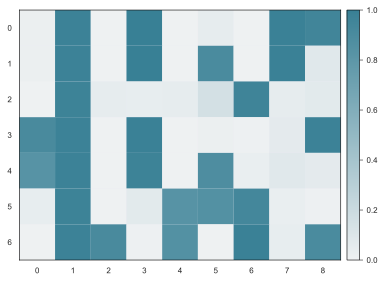

In [60]:
def remove_duplicates(a, min_occurence=1):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a, dtype=torch.float32)

    assert len(a.shape) == 2

    rounded, counts = np.unique(round_tensor(a, decimals=2), axis=0, return_counts=True)
    rounded = np.array([
        *map(
            lambda x: x[1],
            filter(lambda x: counts[x[0]] > min_occurence, enumerate(rounded)),
        ),
    ])
    counts = counts[counts > min_occurence]

    indices = set()
    for i, row in enumerate(rounded):
        if i in indices:
            continue

        matches = []

        for j, other_row in enumerate(rounded):
            if i == j or j in indices:
                continue

            if np.all(np.isclose(row, other_row, atol=0.02)):
                matches.append(j)
        
        if len(matches) == 1 and matches[0] < i:
            indices.add(matches[0])
        elif len(matches) > 1:
            indices.update(matches)

    mask = np.ones(len(rounded), dtype=bool)
    mask[[*indices]] = False
    masked_tensor = torch.tensor(rounded[mask, ...])
    masked_counts = counts[mask, ...]

    order = np.array([
        *map(
            lambda x: x[0],
            sorted(
                enumerate(masked_counts),
                key=lambda x: x[1],
                reverse=True,
            ),
        ),
    ])
    return masked_tensor[order], masked_counts[order]


def get_attractors(model, runs=1, steps=10, burn_in_time=None, states_or_activations="states"):
    if burn_in_time is None:
        burn_in_time = steps // 10

    assert steps > burn_in_time
    
    states, activations = iterate(model, runs=runs, steps=steps)
    
    if states_or_activations == "states":
        states = torch.vstack(tuple(states[:, burn_in_time:, :]))
        uniq_states, counts = remove_duplicates(states, min_occurence=5)
        return uniq_states, counts
    else:
        pass

uniq_states, counts = get_attractors(model1, runs=500, steps=50, burn_in_time=25)
uniq_states, counts
plot_tensor(uniq_states);
counts

In [55]:
for x in uniq_states:
    print(get_closest_item(dataloader.dataset.df, x, metric='euclidean'))

('Sunfish', 0.07681145939925624)
('Salmon', 0.1315294777253928)
('Pine', 0.1974841815990733)
('Canary', 0.11445520250043503)
('Robin', 0.23558438796310688)
('Rose', 0.2543619384446677)
('Daisy', 0.219089036213826)


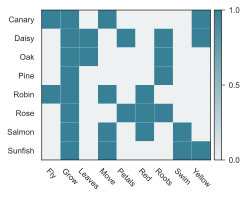

In [7]:
plot_tensor(dataloader.dataset.df);

In [8]:
from torch.utils.data import Dataset, DataLoader

second_epochs = 10000
states_per_run = 5

states, activations = iterate(model1, runs=second_epochs//states_per_run, steps=20)
states = torch.vstack(tuple(states[:, -states_per_run]))

class ReplayDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return {
            'y': self.data[i],
        }

dataloaders = []
for _ in range(second_epochs):
    indices = np.random.choice(list(range(len(states))), size=8, replace=False)
    data = ReplayDataset(states[indices])
    dl = DataLoader(data, shuffle=True, batch_size=4)
    dataloaders.append(dl)

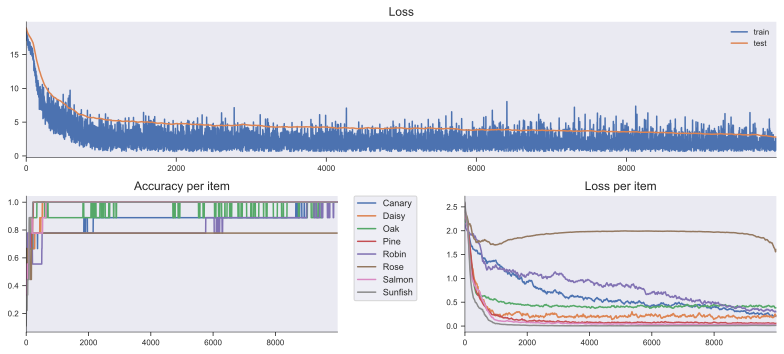

In [9]:
metrics2 = train_model(
    model2 := AutoEncoder(
        sizes=[dataloader.dataset.NUM_ATTRIBUTES, 8],
        batch_norm=False,
        dropout=0.15,
    ),
    optimizer2 := torch.optim.Adam(model2.parameters(), lr=1e-3),
    loss_fn2 := torch.nn.MSELoss(reduction="sum"),
    dataloaders,
    test_loader=dataloader,
    epochs=second_epochs,
    l1_lambda=0.005,
    noise_mean=0,
    noise_stdev=1,
)

plot_metrics(metrics2);

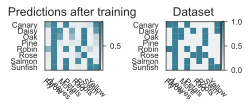

In [10]:
eval_model(model2, dataloader);

In [11]:
plot_grid(model2, dataloader);

[0.63110172 0.23264898]


In [12]:
var = np.var(dataloader.dataset.df)
(var/sum(var)).sort_values()

Grow      0.000000
Fly       0.109091
Leaves    0.109091
Petals    0.109091
Swim      0.109091
Red       0.136364
Yellow    0.136364
Move      0.145455
Roots     0.145455
dtype: float64